In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
import MeshCat as mc
import Distributions
import Random
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using CSV
using DataFrames


  Activating environment at `c:\Users\Daniel\Documents\Python-Projects\AiPEX-Projects\warmstarting_NLPs\JL_presolves\Project.toml`


In [3]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

### Dynamics 

In [4]:
# cartpole 
function dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])


    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    xdot = [qd;qdd]
    return xdot 

end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
     x_mid = 0.5(x1 + x2) + (dt/8) * (dynamics(params, x1, u) - dynamics(params, x2, u))
     res = x1 + (dt/6) * (dynamics(params, x1, u) + 4*dynamics(params, x_mid, u) + dynamics(params, x2, u)) - x2
     return res
end

hermite_simpson (generic function with 1 method)

### Indexing and Constraints

In [5]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function cartpole_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input cartpole LQR cost 
    J = 0 

    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += 0.5*(xi-xg)'*Q*(xi-xg) + 0.5*ui'*R*ui
    end
    
    # dont forget terminal cost 
    xN = Z[idx.x[N]]
    J += 0.5*(xN-xg)'*Qf*(xN-xg)
    return J 
end

function cartpole_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # TODO: create dynamics constraints using hermite simpson 

    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function cartpole_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    
    # TODO: return all of the equality constraints 

    
    return [Z[idx.x[1]] - xic; Z[idx.x[end]] - xg; cartpole_dynamics_constraints(params, Z)] 
end

    


cartpole_equality_constraint (generic function with 1 method)

## NLP Formulation

In [23]:
function solve_cartpole_swingup(σ, z0=nothing; verbose=true)
    
    # problem size 
    nx = 4 
    nu = 1 
    dt = 0.1
    tf = 3.0
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = 1*diagm(ones(nx))
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    # xic = [0, 0, 0, 0]
    xic = [σ[1], σ[2], 0, 0]
    xg = [0, pi, 0, 0]
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 1.0, mp = 0.2, l = 0.5)
    
    # TODO: primal bounds 
    x_l = fill(-Inf, idx.nz)
    x_u = fill(Inf, idx.nz)
    
    # for i = 1:(N-1)
    #     x_l[idx.u[i]] .= -20
    #     x_u[idx.u[i]] .= 20
    # end

    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    if z0 == nothing # if no initial guess is provided, use a straight line between xic and xg
        z0 = zeros(idx.nz)
        interpolated_x = interpolate_pose(xic, xg, N)
        for i = 1:N
            z0[idx.x[i]] = interpolated_x[i]
        end
        z0 += 0.001*randn(idx.nz)
    else # if an initial guess is provided, use it plus noise
        z0 += 0.001*randn(idx.nz)
    end
    
    # diff type
    diff_type = :auto 
    
        
    Z, obj, solve_time_sec, term_status = fmincon(cartpole_cost,cartpole_equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)


    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, obj, solve_time_sec, term_status, t_vec, params 
end


solve_cartpole_swingup (generic function with 1 method)

## Interpolated initialization

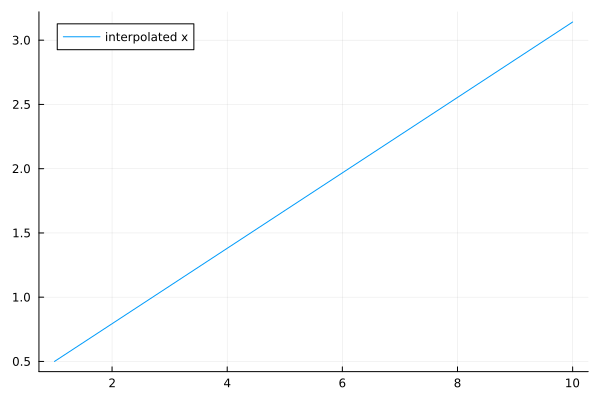

In [7]:
function interpolate_pose(x0::Vector, x1::Vector, N)
    X = [x0 + (x1 - x0) * i/(N-1) for i = 0:(N-1)]
    return X
end

x0 = [0.0, 0.5, 0.0, 0.0]
x1 = [0.0, pi, 0.0, 0.0]
interpolated_x = interpolate_pose(x0, x1, 10)
Xm = hcat(interpolated_x...)
display(plot(Xm'[:,2], label="interpolated x"))

## Solve cartpole for a single parameter sample

[0.0, 6.1086523819801535, 0.0, 0.0, 0.0, 0.0, 6.009750391033808, 0.0, 0.0, 0.0, 0.0, 5.910848400087462, 0.0, 0.0, 0.0, 0.0, 5.811946409141117, 0.0, 0.0, 0.0, 0.0, 5.713044418194772, 0.0, 0.0, 0.0, 0.0, 5.614142427248427, 0.0, 0.0, 0.0, 0.0, 5.515240436302081, 0.0, 0.0, 0.0, 0.0, 5.416338445355736, 0.0, 0.0, 0.0, 0.0, 5.317436454409391, 0.0, 0.0, 0.0, 0.0, 5.218534463463046, 0.0, 0.0, 0.0, 0.0, 5.1196324725167, 0.0, 0.0, 0.0, 0.0, 5.020730481570355, 0.0, 0.0, 0.0, 0.0, 4.9218284906240095, 0.0, 0.0, 0.0, 0.0, 4.8229264996776635, 0.0, 0.0, 0.0, 0.0, 4.724024508731318, 0.0, 0.0, 0.0, 0.0, 4.625122517784973, 0.0, 0.0, 0.0, 0.0, 4.526220526838628, 0.0, 0.0, 0.0, 0.0, 4.427318535892283, 0.0, 0.0, 0.0, 0.0, 4.328416544945937, 0.0, 0.0, 0.0, 0.0, 4.229514553999592, 0.0, 0.0, 0.0, 0.0, 4.130612563053247, 0.0, 0.0, 0.0, 0.0, 4.031710572106901, 0.0, 0.0, 0.0, 0.0, 3.9328085811605558, 0.0, 0.0, 0.0, 0.0, 3.83390659021421, 0.0, 0.0, 0.0, 0.0, 3.735004599267865, 0.0, 0.0, 0.0, 0.0, 3.63610260832152, 

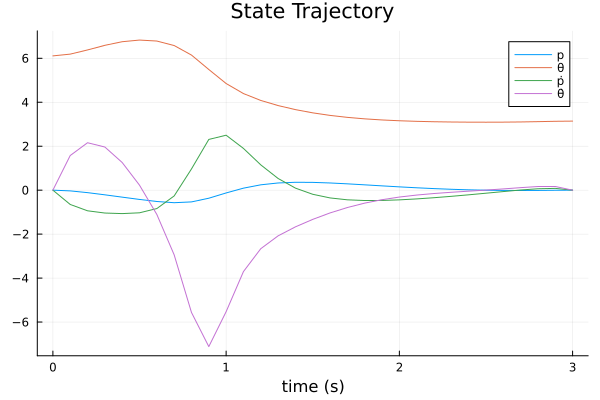

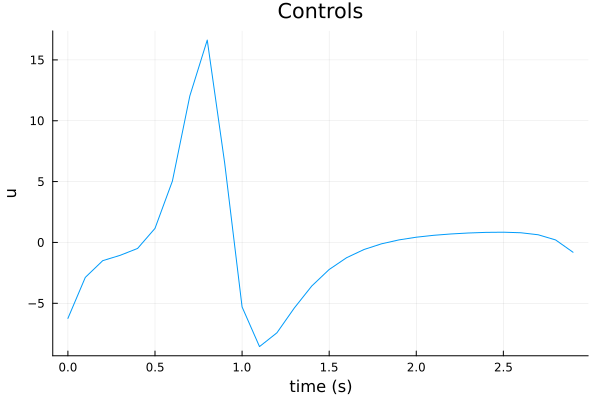

UndefVarError: UndefVarError: len not defined

In [8]:
σ = [0.0, deg2rad(350), 0, 0]

X, U, obj, solve_time_sec, term_status, t_vec, params = solve_cartpole_swingup(σ; verbose=true)

# --------------testing------------------

Xm = hcat(X...)
Um = hcat(U...)

# --------------plotting-----------------
display(plot(t_vec, Xm', label = ["p" "θ" "ṗ" "θ̇"], xlabel = "time (s)", title = "State Trajectory"))
display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))
len(t_vec)



In [9]:
display(animate_cartpole(X, 0.1))
# animate_cartpole(X, 0.05)


┌ Info: Listening on: 127.0.0.1:8700, thread id: 1
└ @ HTTP.Servers C:\Users\Daniel\.julia\packages\HTTP\sJD5V\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\Daniel\.julia\packages\MeshCat\0RCA3\src\visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8700), "127.0.0.1", "8700", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x0000000000001da4) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x000000008c6ed5f0, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

## Solve the DIRCOL NLP for a parameter set

In [16]:
## Define upper and lower bounds of the parameters for the Paramaetric Optimal Control Problem
# using the xic of the cartpole
using Random, Distributions, CSV, DataFrames, ProgressMeter
Random.seed!(123)

N = 50 # number of samples
# σ_lower = [-1.0, 0]
# σ_upper = [1.0, 2*pi]
σ_lower = [-0.5, -pi/2]
σ_upper = [0.5, pi/2]

# Randomly sample the iid parameters uniformly from the given bounds
d = Product(Uniform.(σ_lower, σ_upper))
σ_samples = rand(d, N)
σ_samples = eachcol(σ_samples)

# Solve the NLP for the parameter sample set
df = DataFrame(params = Vector{Vector{Float64}}(), X=Vector{Vector{Vector{Float64}}}(), U=Vector{Vector{Vector{Float64}}}(), obj = Float64[], solve_time_sec = Float64[], term_status = MOI.TerminationStatusCode[])

p = Progress(N, 1)
i = 1
for σ in σ_samples
    next!(p)
    # z0 = 0.001*randn(idx.nz)
    X, U, obj, solve_time_sec, term_status, t_vec, params = solve_cartpole_swingup(σ, verbose=false)

    # if i % 10 == 0
    #     println("Sample: ", i)
    #     println("------------------")
    #     println("σ: ", σ)
    #     println("Objective Value: ", obj)
    #     println("Termination Status Code: ", term_status)
    #     println("Solve Time: ", solve_time_sec, "s")
    #     println("")
    # end

    push!(df, [σ, X, U, obj, solve_time_sec, term_status])
    i += 1
end



[0.26844767519656987, 1.3839186900429339, 0.0, 0.0, 0.0, 0.2594994193566842, 1.4425078221611625, 0.0, 0.0, 0.0, 0.25055116351679857, 1.5010969542793913, 0.0, 0.0, 0.0, 0.2416029076769129, 1.5596860863976199, 0.0, 0.0, 0.0, 0.23265465183702722, 1.6182752185158484, 0.0, 0.0, 0.0, 0.22370639599714157, 1.676864350634077, 0.0, 0.0, 0.0, 0.2147581401572559, 1.7354534827523058, 0.0, 0.0, 0.0, 0.20580988431737024, 1.7940426148705344, 0.0, 0.0, 0.0, 0.19686162847748456, 1.852631746988763, 0.0, 0.0, 0.0, 0.1879133726375989, 1.9112208791069918, 0.0, 0.0, 0.0, 0.17896511679771326, 1.9698100112252201, 0.0, 0.0, 0.0, 0.1700168609578276, 2.028399143343449, 0.0, 0.0, 0.0, 0.1610686051179419, 2.0869882754616778, 0.0, 0.0, 0.0, 0.15212034927805626, 2.145577407579906, 0.0, 0.0, 0.0, 0.14317209343817058, 2.204166539698135, 0.0, 0.0, 0.0, 0.13422383759828493, 2.2627556718163637, 0.0, 0.0, 0.0, 0.12527558175839928, 2.321344803934592, 0.0, 0.0, 0.0, 0.11632732591851361, 2.379933936052821, 0.0, 0.0, 0.0, 0.10

Progress:   4%|██                                       |  ETA: 0:02:16

[0.17395869456806734, -0.3284437342437001, 0.0, 0.0, 0.0, 0.16816007141579842, -0.21277585464925033, 0.0, 0.0, 0.0, 0.16236144826352952, -0.09710797505480057, 0.0, 0.0, 0.0, 0.1565628251112606, 0.01855990453964923, 0.0, 0.0, 0.0, 0.1507642019589917, 0.13422778413409897, 0.0, 0.0, 0.0, 0.14496557880672278, 0.24989566372854877, 0.0, 0.0, 0.0, 0.13916695565445386, 0.36556354332299856, 0.0, 0.0, 0.0, 0.13336833250218497, 0.48123142291744836, 0.0, 0.0, 0.0, 0.12756970934991604, 0.596899302511898, 0.0, 0.0, 0.0, 0.12177108619764714, 0.7125671821063477, 0.0, 0.0, 0.0, 0.11597246304537823, 0.8282350617007976, 0.0, 0.0, 0.0, 0.11017383989310932, 0.9439029412952475, 0.0, 0.0, 0.0, 0.10437521674084041, 1.0595708208896972, 0.0, 0.0, 0.0, 0.09857659358857149, 1.175238700484147, 0.0, 0.0, 0.0, 0.09277797043630258, 1.2909065800785968, 0.0, 0.0, 0.0, 0.08697934728403367, 1.4065744596730465, 0.0, 0.0, 0.0, 0.08118072413176476, 1.5222423392674962, 0.0, 0.0, 0.0, 0.07538210097949585, 1.637910218861946, 0

Progress:   6%|███                                      |  ETA: 0:02:05

[-0.18675604419248137, 0.5106810172392668, 0.0, 0.0, 0.0, -0.18053084271939865, 0.5983780717842844, 0.0, 0.0, 0.0, -0.17430564124631595, 0.6860751263293019, 0.0, 0.0, 0.0, -0.16808043977323323, 0.7737721808743194, 0.0, 0.0, 0.0, -0.16185523830015053, 0.861469235419337, 0.0, 0.0, 0.0, -0.1556300368270678, 0.9491662899643545, 0.0, 0.0, 0.0, -0.1494048353539851, 1.036863344509372, 0.0, 0.0, 0.0, -0.14317963388090238, 1.1245603990543898, 0.0, 0.0, 0.0, -0.13695443240781968, 1.212257453599407, 0.0, 0.0, 0.0, -0.13072923093473696, 1.2999545081444248, 0.0, 0.0, 0.0, -0.12450402946165426, 1.3876515626894421, 0.0, 0.0, 0.0, -0.11827882798857155, 1.4753486172344599, 0.0, 0.0, 0.0, -0.11205362651548882, 1.5630456717794774, 0.0, 0.0, 0.0, -0.10582842504240611, 1.650742726324495, 0.0, 0.0, 0.0, -0.0996032235693234, 1.7384397808695125, 0.0, 0.0, 0.0, -0.0933780220962407, 1.82613683541453, 0.0, 0.0, 0.0, -0.08715282062315798, 1.9138338899595475, 0.0, 0.0, 0.0, -0.08092761915007525, 2.001530944504565,

Progress:   8%|████                                     |  ETA: 0:01:44

][0.0860221243068029, -1.407015164375847, 0.0, 0.0, 0.0, 0.0831547201632428, -1.2553949037769923, 0.0, 0.0, 0.0, 0.0802873160196827, -1.1037746431781377, 0.0, 0.0, 0.0, 0.0774199118761226, -0.952154382579283, 0.0, 0.0, 0.0, 0.0745525077325625, -0.8005341219804283, 0.0, 0.0, 0.0, 0.07168510358900242, -0.6489138613815737, 0.0, 0.0, 0.0, 0.06881769944544232, -0.4972936007827189, 0.0, 0.0, 0.0, 0.06595029530188222, -0.3456733401838641, 0.0, 0.0, 0.0, 0.06308289115832212, -0.1940530795850095, 0.0, 0.0, 0.0, 0.06021548701476202, -0.04243281898615492, 0.0, 0.0, 0.0, 0.057348082871201925, 0.10918744161269966, 0.0, 0.0, 0.0, 0.05448067872764183, 0.26080770221155447, 0.0, 0.0, 0.0, 0.051613274584081735, 0.4124279628104093, 0.0, 0.0, 0.0, 0.04874587044052164, 0.5640482234092639, 0.0, 0.0, 0.0, 0.045878466296961545, 0.7156684840081189, 0.0, 0.0, 0.0, 0.04301106215340145, 0.8672887446069732, 0.0, 0.0, 0.0, 0.04014365800984135, 1.018909005205828, 0.0, 0.0, 0.0, 0.03727625386628126, 1.170529265804682

Progress:  10%|█████                                    |  ETA: 0:01:42

][-0.23136043145504903, -1.228768805583758, 0.0, 0.0, 0.0, -0.22364841707321406, -1.083090090277973, 0.0, 0.0, 0.0, -0.2159364026913791, -0.937411374972188, 0.0, 0.0, 0.0, -0.20822438830954412, -0.7917326596664028, 0.0, 0.0, 0.0, -0.20051237392770915, -0.6460539443606178, 0.0, 0.0, 0.0, -0.19280035954587418, -0.5003752290548328, 0.0, 0.0, 0.0, -0.18508834516403921, -0.35469651374904765, 0.0, 0.0, 0.0, -0.17737633078220427, -0.20901779844326263, 0.0, 0.0, 0.0, -0.16966431640036927, -0.0633390831374776, 0.0, 0.0, 0.0, -0.16195230201853433, 0.08233963216830742, 0.0, 0.0, 0.0, -0.15424028763669934, 0.22801834747409244, 0.0, 0.0, 0.0, -0.1465282732548644, 0.37369706277987746, 0.0, 0.0, 0.0, -0.13881625887302942, 0.5193757780856627, 0.0, 0.0, 0.0, -0.13110424449119445, 0.6650544933914477, 0.0, 0.0, 0.0, -0.12339223010935949, 0.8107332086972328, 0.0, 0.0, 0.0, -0.11568021572752452, 0.9564119240030178, 0.0, 0.0, 0.0, -0.10796820134568955, 1.1020906393088028, 0.0, 0.0, 0.0, -0.10025618696385458

Progress:  14%|██████                                   |  ETA: 0:01:26

][0.3654121434083455, 0.36911165214154784, 0.0, 0.0, 0.0, 0.3532317386280673, 0.46152768552315604, 0.0, 0.0, 0.0, 0.34105133384778913, 0.5539437189047642, 0.0, 0.0, 0.0, 0.3288709290675109, 0.6463597522863723, 0.0, 0.0, 0.0, 0.31669052428723277, 0.7387757856679805, 0.0, 0.0, 0.0, 0.30451011950695456, 0.8311918190495886, 0.0, 0.0, 0.0, 0.2923297147266764, 0.9236078524311968, 0.0, 0.0, 0.0, 0.2801493099463982, 1.016023885812805, 0.0, 0.0, 0.0, 0.26796890516612004, 1.1084399191944132, 0.0, 0.0, 0.0, 0.25578850038584183, 1.2008559525760214, 0.0, 0.0, 0.0, 0.24360809560556368, 1.2932719859576296, 0.0, 0.0, 0.0, 0.2314276908252855, 1.3856880193392378, 0.0, 0.0, 0.0, 0.2192472860450073, 1.4781040527208458, 0.0, 0.0, 0.0, 0.2070668812647291, 1.570520086102454, 0.0, 0.0, 0.0, 0.19488647648445095, 1.6629361194840622, 0.0, 0.0, 0.0, 0.18270607170417275, 1.7553521528656706, 0.0, 0.0, 0.0, 0.17052566692389456, 1.8477681862472786, 0.0, 0.0, 0.0, 0.15834526214361638, 1.9401842196288865, 0.0, 0.0, 0.0

Progress:  16%|███████                                  |  ETA: 0:01:21

][-0.21430209961468227, -0.1135773449311932, 0.0, 0.0, 0.0, -0.20715869629419287, -0.005071678313826988, 0.0, 0.0, 0.0, -0.20001529297370346, 0.10343398830353923, 0.0, 0.0, 0.0, -0.19287188965321406, 0.21193965492090538, 0.0, 0.0, 0.0, -0.18572848633272465, 0.32044532153827165, 0.0, 0.0, 0.0, -0.17858508301223522, 0.4289509881556379, 0.0, 0.0, 0.0, -0.1714416796917458, 0.537456654773004, 0.0, 0.0, 0.0, -0.1642982763712564, 0.6459623213903702, 0.0, 0.0, 0.0, -0.157154873050767, 0.7544679880077365, 0.0, 0.0, 0.0, -0.1500114697302776, 0.8629736546251027, 0.0, 0.0, 0.0, -0.14286806640978816, 0.971479321242469, 0.0, 0.0, 0.0, -0.13572466308929876, 1.079984987859835, 0.0, 0.0, 0.0, -0.12858125976880935, 1.1884906544772011, 0.0, 0.0, 0.0, -0.12143785644831996, 1.2969963210945676, 0.0, 0.0, 0.0, -0.11429445312783054, 1.4055019877119337, 0.0, 0.0, 0.0, -0.10715104980734114, 1.5140076543293, 0.0, 0.0, 0.0, -0.10000764648685173, 1.6225133209466662, 0.0, 0.0, 0.0, -0.09286424316636231, 1.731018987

Progress:  18%|████████                                 |  ETA: 0:01:24

][-0.2241808848571949, -0.16786137341799523, 0.0, 0.0, 0.0, -0.2167081886952884, -0.057546239184402284, 0.0, 0.0, 0.0, -0.2092354925333819, 0.05276889504919066, 0.0, 0.0, 0.0, -0.2017627963714754, 0.16308402928278365, 0.0, 0.0, 0.0, -0.1942901002095689, 0.27339916351637655, 0.0, 0.0, 0.0, -0.18681740404766242, 0.38371429774996957, 0.0, 0.0, 0.0, -0.1793447078857559, 0.49402943198356253, 0.0, 0.0, 0.0, -0.17187201172384942, 0.6043445662171555, 0.0, 0.0, 0.0, -0.16439931556194293, 0.7146597004507483, 0.0, 0.0, 0.0, -0.15692661940003644, 0.8249748346843413, 0.0, 0.0, 0.0, -0.14945392323812995, 0.9352899689179344, 0.0, 0.0, 0.0, -0.14198122707622346, 1.0456051031515272, 0.0, 0.0, 0.0, -0.13450853091431694, 1.1559202373851203, 0.0, 0.0, 0.0, -0.12703583475241043, 1.2662353716187131, 0.0, 0.0, 0.0, -0.11956313859050395, 1.3765505058523062, 0.0, 0.0, 0.0, -0.11209044242859746, 1.486865640085899, 0.0, 0.0, 0.0, -0.10461774626669094, 1.597180774319492, 0.0, 0.0, 0.0, -0.09714505010478444, 1.707

Progress:  20%|█████████                                |  ETA: 0:01:22

[0.08231778008704693, -0.7666073451483812, 0.0, 0.0, 0.0, 0.07957385408414537, -0.6363340118571088, 0.0, 0.0, 0.0, 0.07682992808124381, -0.5060606785658363, 0.0, 0.0, 0.0, 0.07408600207834223, -0.3757873452745638, 0.0, 0.0, 0.0, 0.07134207607544067, -0.24551401198329126, 0.0, 0.0, 0.0, 0.06859815007253911, -0.1152406786920187, 0.0, 0.0, 0.0, 0.06585422406963755, 0.015032654599253625, 0.0, 0.0, 0.0, 0.06311029806673599, 0.14530598789052607, 0.0, 0.0, 0.0, 0.06036637206383442, 0.27557932118179873, 0.0, 0.0, 0.0, 0.05762244606093285, 0.4058526544730712, 0.0, 0.0, 0.0, 0.05487852005803129, 0.5361259877643438, 0.0, 0.0, 0.0, 0.05213459405512973, 0.6663993210556161, 0.0, 0.0, 0.0, 0.04939066805222816, 0.7966726543468885, 0.0, 0.0, 0.0, 0.046646742049326596, 0.9269459876381612, 0.0, 0.0, 0.0, 0.04390281604642503, 1.0572193209294334, 0.0, 0.0, 0.0, 0.041158890043523466, 1.187492654220706, 0.0, 0.0, 0.0, 0.038414964040621905, 1.3177659875119787, 0.0, 0.0, 0.0, 0.035671038037720336, 1.4480393208

Progress:  22%|██████████                               |  ETA: 0:01:20

[0.20586033164675155, -0.6535195488073193, 0.0, 0.0, 0.0, 0.19899832059185982, -0.5270158087274156, 0.0, 0.0, 0.0, 0.19213630953696811, -0.4005120686475118, 0.0, 0.0, 0.0, 0.18527429848207638, -0.2740083285676081, 0.0, 0.0, 0.0, 0.17841228742718468, -0.1475045884877043, 0.0, 0.0, 0.0, 0.17155027637229295, -0.021000848407800587, 0.0, 0.0, 0.0, 0.16468826531740124, 0.10550289167210314, 0.0, 0.0, 0.0, 0.1578262542625095, 0.23200663175200686, 0.0, 0.0, 0.0, 0.1509642432076178, 0.3585103718319107, 0.0, 0.0, 0.0, 0.14410223215272608, 0.4850141119118143, 0.0, 0.0, 0.0, 0.13724022109783435, 0.6115178519917182, 0.0, 0.0, 0.0, 0.13037821004294264, 0.738021592071622, 0.0, 0.0, 0.0, 0.12351619898805093, 0.8645253321515256, 0.0, 0.0, 0.0, 0.11665418793315922, 0.9910290722314294, 0.0, 0.0, 0.0, 0.10979217687826749, 1.117532812311333, 0.0, 0.0, 0.0, 0.10293016582337576, 1.244036552391237, 0.0, 0.0, 0.0, 0.09606815476848406, 1.3705402924711407, 0.0, 0.0, 0.0, 0.08920614371359234, 1.4970440325510443, 0

Progress:  24%|██████████                               |  ETA: 0:01:16

[-0.21893410489854248, 0.9202699692274736, 0.0, 0.0, 0.0, -0.2116363014019244, 0.9943140587062176, 0.0, 0.0, 0.0, -0.2043384979053063, 1.0683581481849616, 0.0, 0.0, 0.0, -0.19704069440868824, 1.1424022376637055, 0.0, 0.0, 0.0, -0.18974289091207014, 1.2164463271424495, 0.0, 0.0, 0.0, -0.18244508741545207, 1.2904904166211937, 0.0, 0.0, 0.0, -0.175147283918834, 1.3645345060999374, 0.0, 0.0, 0.0, -0.1678494804222159, 1.4385785955786816, 0.0, 0.0, 0.0, -0.16055167692559782, 1.5126226850574254, 0.0, 0.0, 0.0, -0.15325387342897973, 1.5866667745361696, 0.0, 0.0, 0.0, -0.14595606993236165, 1.6607108640149135, 0.0, 0.0, 0.0, -0.13865826643574358, 1.7347549534936575, 0.0, 0.0, 0.0, -0.13136046293912548, 1.8087990429724015, 0.0, 0.0, 0.0, -0.12406265944250741, 1.8828431324511454, 0.0, 0.0, 0.0, -0.11676485594588933, 1.9568872219298894, 0.0, 0.0, 0.0, -0.10946705244927123, 2.0309313114086334, 0.0, 0.0, 0.0, -0.10216924895265315, 2.104975400887377, 0.0, 0.0, 0.0, -0.09487144545603508, 2.179019490366

Progress:  28%|████████████                             |  ETA: 0:01:06

[0.1142547706656345, 0.9508491801756871, 0.0, 0.0, 0.0, 0.11044627831011335, 1.023873962622824, 0.0, 0.0, 0.0, 0.1066377859545922, 1.0968987450699608, 0.0, 0.0, 0.0, 0.10282929359907104, 1.1699235275170978, 0.0, 0.0, 0.0, 0.0990208012435499, 1.2429483099642344, 0.0, 0.0, 0.0, 0.09521230888802874, 1.3159730924113715, 0.0, 0.0, 0.0, 0.09140381653250759, 1.3889978748585083, 0.0, 0.0, 0.0, 0.08759532417698646, 1.4620226573056452, 0.0, 0.0, 0.0, 0.08378683182146529, 1.535047439752782, 0.0, 0.0, 0.0, 0.07997833946594415, 1.6080722221999189, 0.0, 0.0, 0.0, 0.07616984711042299, 1.6810970046470557, 0.0, 0.0, 0.0, 0.07236135475490185, 1.7541217870941925, 0.0, 0.0, 0.0, 0.0685528623993807, 1.8271465695413296, 0.0, 0.0, 0.0, 0.06474437004385955, 1.9001713519884664, 0.0, 0.0, 0.0, 0.0609358776883384, 1.9731961344356033, 0.0, 0.0, 0.0, 0.05712738533281725, 2.0462209168827403, 0.0, 0.0, 0.0, 0.0533188929772961, 2.119245699329877, 0.0, 0.0, 0.0, 0.04951040062177495, 2.192270481777014, 0.0, 0.0, 0.0, 0

Progress:  30%|█████████████                            |  ETA: 0:01:03

][0.055668300903269685, 1.3847583420703407, 0.0, 0.0, 0.0, 0.05381269087316069, 1.4433194857876557, 0.0, 0.0, 0.0, 0.05195708084305171, 1.501880629504971, 0.0, 0.0, 0.0, 0.050101470812942715, 1.560441773222286, 0.0, 0.0, 0.0, 0.04824586078283373, 1.619002916939601, 0.0, 0.0, 0.0, 0.04639025075272474, 1.677564060656916, 0.0, 0.0, 0.0, 0.044534640722615745, 1.7361252043742312, 0.0, 0.0, 0.0, 0.04267903069250676, 1.7946863480915463, 0.0, 0.0, 0.0, 0.04082342066239777, 1.8532474918088613, 0.0, 0.0, 0.0, 0.03896781063228878, 1.9118086355261763, 0.0, 0.0, 0.0, 0.03711220060217979, 1.9703697792434913, 0.0, 0.0, 0.0, 0.0352565905720708, 2.0289309229608063, 0.0, 0.0, 0.0, 0.03340098054196181, 2.087492066678122, 0.0, 0.0, 0.0, 0.03154537051185282, 2.146053210395437, 0.0, 0.0, 0.0, 0.02968976048174383, 2.204614354112752, 0.0, 0.0, 0.0, 0.027834150451634843, 2.263175497830067, 0.0, 0.0, 0.0, 0.025978540421525854, 2.321736641547382, 0.0, 0.0, 0.0, 0.024122930391416865, 2.380297785264697, 0.0, 0.0, 

Progress:  34%|██████████████                           |  ETA: 0:00:56

[-0.1437789149077815, 1.2595417655062575, 0.0, 0.0, 0.0, -0.13898628441085545, 1.322276795109042, 0.0, 0.0, 0.0, -0.1341936539139294, 1.3850118247118266, 0.0, 0.0, 0.0, -0.12940102341700335, 1.447746854314611, 0.0, 0.0, 0.0, -0.1246083929200773, 1.5104818839173957, 0.0, 0.0, 0.0, -0.11981576242315124, 1.5732169135201801, 0.0, 0.0, 0.0, -0.1150231319262252, 1.6359519431229645, 0.0, 0.0, 0.0, -0.11023050142929915, 1.6986869727257492, 0.0, 0.0, 0.0, -0.1054378709323731, 1.7614220023285336, 0.0, 0.0, 0.0, -0.10064524043544705, 1.8241570319313183, 0.0, 0.0, 0.0, -0.09585260993852099, 1.8868920615341027, 0.0, 0.0, 0.0, -0.09105997944159494, 1.9496270911368874, 0.0, 0.0, 0.0, -0.08626734894466889, 2.012362120739672, 0.0, 0.0, 0.0, -0.08147471844774284, 2.0750971503424562, 0.0, 0.0, 0.0, -0.0766820879508168, 2.137832179945241, 0.0, 0.0, 0.0, -0.07188945745389076, 2.2005672095480255, 0.0, 0.0, 0.0, -0.0670968269569647, 2.2633022391508097, 0.0, 0.0, 0.0, -0.06230419646003864, 2.3260372687535944,

Progress:  38%|████████████████                         |  ETA: 0:00:51

][0.40068147898270046, 1.3832408644435503, 0.0, 0.0, 0.0, 0.3873254296832771, 1.441852590748425, 0.0, 0.0, 0.0, 0.37396938038385374, 1.5004643170532999, 0.0, 0.0, 0.0, 0.3606133310844304, 1.5590760433581745, 0.0, 0.0, 0.0, 0.34725728178500703, 1.6176877696630494, 0.0, 0.0, 0.0, 0.33390123248558373, 1.676299495967924, 0.0, 0.0, 0.0, 0.3205451831861604, 1.734911222272799, 0.0, 0.0, 0.0, 0.307189133886737, 1.7935229485776736, 0.0, 0.0, 0.0, 0.29383308458731366, 1.8521346748825485, 0.0, 0.0, 0.0, 0.2804770352878903, 1.9107464011874231, 0.0, 0.0, 0.0, 0.267120985988467, 1.9693581274922978, 0.0, 0.0, 0.0, 0.25376493668904365, 2.0279698537971727, 0.0, 0.0, 0.0, 0.24040888738962027, 2.0865815801020475, 0.0, 0.0, 0.0, 0.22705283809019694, 2.145193306406922, 0.0, 0.0, 0.0, 0.21369678879077356, 2.203805032711797, 0.0, 0.0, 0.0, 0.20034073949135023, 2.2624167590166717, 0.0, 0.0, 0.0, 0.18698469019192687, 2.3210284853215466, 0.0, 0.0, 0.0, 0.17362864089250354, 2.3796402116264215, 0.0, 0.0, 0.0, 0.1

Progress:  44%|███████████████████                      |  ETA: 0:00:44

[-0.12501972979759235, 0.8160433113143464, 0.0, 0.0, 0.0, -0.12085240547100594, 0.8935616227235279, 0.0, 0.0, 0.0, -0.11668508114441953, 0.9710799341327094, 0.0, 0.0, 0.0, -0.11251775681783312, 1.048598245541891, 0.0, 0.0, 0.0, -0.1083504324912467, 1.1261165569510725, 0.0, 0.0, 0.0, -0.1041831081646603, 1.2036348683602542, 0.0, 0.0, 0.0, -0.10001578383807389, 1.2811531797694358, 0.0, 0.0, 0.0, -0.09584845951148746, 1.3586714911786173, 0.0, 0.0, 0.0, -0.09168113518490106, 1.4361898025877988, 0.0, 0.0, 0.0, -0.08751381085831464, 1.5137081139969806, 0.0, 0.0, 0.0, -0.08334648653172824, 1.591226425406162, 0.0, 0.0, 0.0, -0.07917916220514182, 1.6687447368153436, 0.0, 0.0, 0.0, -0.0750118378785554, 1.7462630482245252, 0.0, 0.0, 0.0, -0.070844513551969, 1.8237813596337067, 0.0, 0.0, 0.0, -0.06667718922538259, 1.9012996710428882, 0.0, 0.0, 0.0, -0.06250986489879617, 1.9788179824520697, 0.0, 0.0, 0.0, -0.058342540572209764, 2.0563362938612513, 0.0, 0.0, 0.0, -0.05417521624562335, 2.133854605270

Progress:  46%|███████████████████                      |  ETA: 0:00:42

][-0.3082198004622341, -0.8339556385821986, 0.0, 0.0, 0.0, -0.29794580711349294, -0.7014373621764656, 0.0, 0.0, 0.0, -0.2876718137647518, -0.5689190857707325, 0.0, 0.0, 0.0, -0.2773978204160107, -0.43640080936499936, 0.0, 0.0, 0.0, -0.26712382706726956, -0.30388253295926637, 0.0, 0.0, 0.0, -0.2568498337185284, -0.17136425655353327, 0.0, 0.0, 0.0, -0.24657584036978725, -0.03884598014780016, 0.0, 0.0, 0.0, -0.23630184702104612, 0.09367229625793283, 0.0, 0.0, 0.0, -0.226027853672305, 0.22619057266366582, 0.0, 0.0, 0.0, -0.21575386032356386, 0.3587088490693989, 0.0, 0.0, 0.0, -0.20547986697482273, 0.49122712547513203, 0.0, 0.0, 0.0, -0.19520587362608158, 0.6237454018808651, 0.0, 0.0, 0.0, -0.18493188027734045, 0.7562636782865982, 0.0, 0.0, 0.0, -0.1746578869285993, 0.8887819546923313, 0.0, 0.0, 0.0, -0.16438389357985816, 1.0213002310980643, 0.0, 0.0, 0.0, -0.15410990023111706, 1.1538185075037974, 0.0, 0.0, 0.0, -0.1438359068823759, 1.28633678390953, 0.0, 0.0, 0.0, -0.13356191353363475, 1.4

Progress:  48%|████████████████████                     |  ETA: 0:00:41

[-0.4023301966832722, 0.3992744243798849, 0.0, 0.0, 0.0, -0.38891919012716314, 0.4906850320202152, 0.0, 0.0, 0.0, -0.37550818357105403, 0.5820956396605454, 0.0, 0.0, 0.0, -0.362097177014945, 0.6735062473008757, 0.0, 0.0, 0.0, -0.3486861704588359, 0.764916854941206, 0.0, 0.0, 0.0, -0.3352751639027268, 0.8563274625815362, 0.0, 0.0, 0.0, -0.3218641573466178, 0.9477380702218666, 0.0, 0.0, 0.0, -0.30845315079050867, 1.0391486778621968, 0.0, 0.0, 0.0, -0.2950421442343996, 1.130559285502527, 0.0, 0.0, 0.0, -0.2816311376782905, 1.2219698931428573, 0.0, 0.0, 0.0, -0.26822013112218146, 1.3133805007831874, 0.0, 0.0, 0.0, -0.2548091245660724, 1.4047911084235178, 0.0, 0.0, 0.0, -0.2413981180099633, 1.4962017160638483, 0.0, 0.0, 0.0, -0.22798711145385422, 1.5876123237041784, 0.0, 0.0, 0.0, -0.21457610489774517, 1.6790229313445086, 0.0, 0.0, 0.0, -0.2011650983416361, 1.770433538984839, 0.0, 0.0, 0.0, -0.18775409178552702, 1.8618441466251692, 0.0, 0.0, 0.0, -0.17434308522941794, 1.9532547542654994, 0.

Progress:  50%|█████████████████████                    |  ETA: 0:00:39

][0.44669653468451886, 0.14735417383349447, 0.0, 0.0, 0.0, 0.4318066501950349, 0.24716212315870445, 0.0, 0.0, 0.0, 0.4169167657055509, 0.3469700724839144, 0.0, 0.0, 0.0, 0.402026881216067, 0.4467780218091244, 0.0, 0.0, 0.0, 0.387136996726583, 0.5465859711343344, 0.0, 0.0, 0.0, 0.37224711223709905, 0.6463939204595442, 0.0, 0.0, 0.0, 0.3573572277476151, 0.7462018697847543, 0.0, 0.0, 0.0, 0.3424673432581311, 0.8460098191099642, 0.0, 0.0, 0.0, 0.3275774587686472, 0.9458177684351742, 0.0, 0.0, 0.0, 0.31268757427916316, 1.0456257177603843, 0.0, 0.0, 0.0, 0.29779768978967924, 1.145433667085594, 0.0, 0.0, 0.0, 0.2829078053001953, 1.245241616410804, 0.0, 0.0, 0.0, 0.2680179208107113, 1.3450495657360142, 0.0, 0.0, 0.0, 0.2531280363212274, 1.4448575150612242, 0.0, 0.0, 0.0, 0.2382381518317434, 1.544665464386434, 0.0, 0.0, 0.0, 0.22334826734225943, 1.644473413711644, 0.0, 0.0, 0.0, 0.20845838285277546, 1.7442813630368539, 0.0, 0.0, 0.0, 0.19356849836329149, 1.8440893123620639, 0.0, 0.0, 0.0, 0.178

Progress:  52%|██████████████████████                   |  ETA: 0:00:37

][-0.377405563918201, -1.2240758243540215, 0.0, 0.0, 0.0, -0.364825378454261, -1.0785535417558942, 0.0, 0.0, 0.0, -0.3522451929903209, -0.9330312591577672, 0.0, 0.0, 0.0, -0.3396650075263809, -0.78750897655964, 0.0, 0.0, 0.0, -0.3270848220624409, -0.6419866939615129, 0.0, 0.0, 0.0, -0.31450463659850086, -0.4964644113633858, 0.0, 0.0, 0.0, -0.3019244511345608, -0.35094212876525854, 0.0, 0.0, 0.0, -0.28934426567062077, -0.2054198461671315, 0.0, 0.0, 0.0, -0.27676408020668075, -0.05989756356900422, 0.0, 0.0, 0.0, -0.26418389474274073, 0.08562471902912283, 0.0, 0.0, 0.0, -0.2516037092788007, 0.23114700162724988, 0.0, 0.0, 0.0, -0.23902352381486064, 0.37666928422537715, 0.0, 0.0, 0.0, -0.22644333835092062, 0.5221915668235044, 0.0, 0.0, 0.0, -0.2138631528869806, 0.6677138494216315, 0.0, 0.0, 0.0, -0.20128296742304055, 0.8132361320197585, 0.0, 0.0, 0.0, -0.18870278195910048, 0.9587584146178858, 0.0, 0.0, 0.0, -0.17612259649516046, 1.104280697216013, 0.0, 0.0, 0.0, -0.16354241103122044, 1.2498

Progress:  56%|███████████████████████                  |  ETA: 0:00:33

][-0.4665244500945205, 0.6530239940914395, 0.0, 0.0, 0.0, -0.4509736350913698, 0.7359762827413846, 0.0, 0.0, 0.0, -0.43542282008821914, 0.8189285713913298, 0.0, 0.0, 0.0, -0.41987200508506844, 0.9018808600412749, 0.0, 0.0, 0.0, -0.40432119008191775, 0.9848331486912201, 0.0, 0.0, 0.0, -0.38877037507876705, 1.067785437341165, 0.0, 0.0, 0.0, -0.3732195600756164, 1.1507377259911102, 0.0, 0.0, 0.0, -0.3576687450724657, 1.2336900146410552, 0.0, 0.0, 0.0, -0.342117930069315, 1.3166423032910006, 0.0, 0.0, 0.0, -0.3265671150661643, 1.3995945919409456, 0.0, 0.0, 0.0, -0.3110163000630136, 1.4825468805908906, 0.0, 0.0, 0.0, -0.295465485059863, 1.5654991692408358, 0.0, 0.0, 0.0, -0.2799146700567123, 1.648451457890781, 0.0, 0.0, 0.0, -0.26436385505356164, 1.7314037465407262, 0.0, 0.0, 0.0, -0.2488130400504109, 1.8143560351906711, 0.0, 0.0, 0.0, -0.23326222504726024, 1.8973083238406163, 0.0, 0.0, 0.0, -0.21771141004410957, 1.9802606124905615, 0.0, 0.0, 0.0, -0.2021605950409589, 2.0632129011405067, 0.

Progress:  58%|████████████████████████                 |  ETA: 0:00:31

[-0.19839659789096853, -0.5942403870644144, 0.0, 0.0, 0.0, -0.19178337796126957, -0.46971261904260747, 0.0, 0.0, 0.0, -0.18517015803157064, -0.34518485102080054, 0.0, 0.0, 0.0, -0.17855693810187168, -0.22065708299899361, 0.0, 0.0, 0.0, -0.17194371817217272, -0.09612931497718674, 0.0, 0.0, 0.0, -0.16533049824247378, 0.028398453044620187, 0.0, 0.0, 0.0, -0.15871727831277482, 0.15292622106642717, 0.0, 0.0, 0.0, -0.15210405838307586, 0.27745398908823404, 0.0, 0.0, 0.0, -0.14549083845337693, 0.4019817571100409, 0.0, 0.0, 0.0, -0.13887761852367797, 0.5265095251318479, 0.0, 0.0, 0.0, -0.13226439859397904, 0.6510372931536548, 0.0, 0.0, 0.0, -0.12565117866428005, 0.7755650611754616, 0.0, 0.0, 0.0, -0.11903795873458112, 0.9000928291972687, 0.0, 0.0, 0.0, -0.11242473880488217, 1.0246205972190756, 0.0, 0.0, 0.0, -0.10581151887518321, 1.1491483652408825, 0.0, 0.0, 0.0, -0.09919829894548426, 1.2736761332626894, 0.0, 0.0, 0.0, -0.09258507901578532, 1.3982039012844962, 0.0, 0.0, 0.0, -0.08597185908608

Progress:  60%|█████████████████████████                |  ETA: 0:00:31

][-0.04152429387917134, -0.1029858376072974, 0.0, 0.0, 0.0, -0.04014015074986563, 0.005166778765938948, 0.0, 0.0, 0.0, -0.03875600762055991, 0.1133193951391753, 0.0, 0.0, 0.0, -0.0373718644912542, 0.2214720115124117, 0.0, 0.0, 0.0, -0.03598772136194849, 0.329624627885648, 0.0, 0.0, 0.0, -0.03460357823264278, 0.4377772442588843, 0.0, 0.0, 0.0, -0.03321943510333707, 0.5459298606321208, 0.0, 0.0, 0.0, -0.03183529197403136, 0.6540824770053572, 0.0, 0.0, 0.0, -0.030451148844725648, 0.7622350933785934, 0.0, 0.0, 0.0, -0.029067005715419935, 0.8703877097518298, 0.0, 0.0, 0.0, -0.027682862586114222, 0.978540326125066, 0.0, 0.0, 0.0, -0.026298719456808513, 1.0866929424983025, 0.0, 0.0, 0.0, -0.024914576327502803, 1.194845558871539, 0.0, 0.0, 0.0, -0.02353043319819709, 1.3029981752447752, 0.0, 0.0, 0.0, -0.02214629006889138, 1.4111507916180117, 0.0, 0.0, 0.0, -0.02076214693958567, 1.519303407991248, 0.0, 0.0, 0.0, -0.019378003810279956, 1.6274560243644842, 0.0, 0.0, 0.0, -0.017993860680974246, 1.

Progress:  62%|██████████████████████████               |  ETA: 0:00:30

][-0.14706702378297365, 0.8729499373403642, 0.0, 0.0, 0.0, -0.14216478965687454, 0.9485713612153451, 0.0, 0.0, 0.0, -0.1372625555307754, 1.024192785090326, 0.0, 0.0, 0.0, -0.1323603214046763, 1.0998142089653071, 0.0, 0.0, 0.0, -0.12745808727857716, 1.175435632840288, 0.0, 0.0, 0.0, -0.12255585315247804, 1.251057056715269, 0.0, 0.0, 0.0, -0.11765361902637891, 1.32667848059025, 0.0, 0.0, 0.0, -0.1127513849002798, 1.402299904465231, 0.0, 0.0, 0.0, -0.10784915077418067, 1.477921328340212, 0.0, 0.0, 0.0, -0.10294691664808156, 1.5535427522151928, 0.0, 0.0, 0.0, -0.09804468252198242, 1.6291641760901738, 0.0, 0.0, 0.0, -0.09314244839588331, 1.7047855999651547, 0.0, 0.0, 0.0, -0.08824021426978419, 1.7804070238401357, 0.0, 0.0, 0.0, -0.08333798014368507, 1.8560284477151168, 0.0, 0.0, 0.0, -0.07843574601758595, 1.9316498715900976, 0.0, 0.0, 0.0, -0.07353351189148682, 2.0072712954650784, 0.0, 0.0, 0.0, -0.0686312777653877, 2.0828927193400597, 0.0, 0.0, 0.0, -0.06372904363928858, 2.158514143215041,

Progress:  64%|███████████████████████████              |  ETA: 0:00:29

[-0.3798448682190021, -1.3289826605563186, 0.0, 0.0, 0.0, -0.36718337261170203, -1.179963483418115, 0.0, 0.0, 0.0, -0.35452187700440196, -1.030944306279911, 0.0, 0.0, 0.0, -0.3418603813971019, -0.8819251291417074, 0.0, 0.0, 0.0, -0.32919888578980183, -0.7329059520035037, 0.0, 0.0, 0.0, -0.31653739018250177, -0.5838867748653, 0.0, 0.0, 0.0, -0.3038758945752017, -0.43486759772709627, 0.0, 0.0, 0.0, -0.2912143989679016, -0.2858484205888925, 0.0, 0.0, 0.0, -0.27855290336060157, -0.1368292434506888, 0.0, 0.0, 0.0, -0.26589140775330145, 0.012189933687514865, 0.0, 0.0, 0.0, -0.25322991214600143, 0.16120911082571854, 0.0, 0.0, 0.0, -0.2405684165387013, 0.31022828796392243, 0.0, 0.0, 0.0, -0.22790692093140125, 0.4592474651021261, 0.0, 0.0, 0.0, -0.2152454253241012, 0.6082666422403298, 0.0, 0.0, 0.0, -0.20258392971680111, 0.7572858193785337, 0.0, 0.0, 0.0, -0.18992243410950105, 0.9063049965167373, 0.0, 0.0, 0.0, -0.17726093850220098, 1.055324173654941, 0.0, 0.0, 0.0, -0.16459944289490092, 1.2043

Progress:  66%|████████████████████████████             |  ETA: 0:00:27

[0.42496491923374835, -0.47457205428828897, 0.0, 0.0, 0.0, 0.41079942192595675, -0.35403323069235293, 0.0, 0.0, 0.0, 0.3966339246181651, -0.23349440709641683, 0.0, 0.0, 0.0, 0.3824684273103735, -0.11295558350048074, 0.0, 0.0, 0.0, 0.3683029300025819, 0.007583240095455301, 0.0, 0.0, 0.0, 0.3541374326947903, 0.12812206369139134, 0.0, 0.0, 0.0, 0.33997193538699866, 0.2486608872873275, 0.0, 0.0, 0.0, 0.32580643807920706, 0.36919971088326353, 0.0, 0.0, 0.0, 0.31164094077141546, 0.48973853447919957, 0.0, 0.0, 0.0, 0.29747544346362387, 0.6102773580751357, 0.0, 0.0, 0.0, 0.28330994615583227, 0.7308161816710717, 0.0, 0.0, 0.0, 0.2691444488480406, 0.8513550052670078, 0.0, 0.0, 0.0, 0.254978951540249, 0.971893828862944, 0.0, 0.0, 0.0, 0.24081345423245742, 1.0924326524588799, 0.0, 0.0, 0.0, 0.2266479569246658, 1.212971476054816, 0.0, 0.0, 0.0, 0.21248245961687415, 1.333510299650752, 0.0, 0.0, 0.0, 0.19831696230908255, 1.4540491232466881, 0.0, 0.0, 0.0, 0.18415146500129095, 1.5745879468426243, 0.0,

Progress:  68%|████████████████████████████             |  ETA: 0:00:26

][0.2844226234383731, 1.098849699182555, 0.0, 0.0, 0.0, 0.2749418693237607, 1.1669411309961295, 0.0, 0.0, 0.0, 0.2654611152091482, 1.235032562809704, 0.0, 0.0, 0.0, 0.2559803610945358, 1.3031239946232787, 0.0, 0.0, 0.0, 0.24649960697992335, 1.3712154264368532, 0.0, 0.0, 0.0, 0.2370188528653109, 1.439306858250428, 0.0, 0.0, 0.0, 0.22753809875069847, 1.5073982900640026, 0.0, 0.0, 0.0, 0.21805734463608606, 1.5754897218775772, 0.0, 0.0, 0.0, 0.2085765905214736, 1.6435811536911518, 0.0, 0.0, 0.0, 0.19909583640686118, 1.7116725855047263, 0.0, 0.0, 0.0, 0.18961508229224872, 1.7797640173183011, 0.0, 0.0, 0.0, 0.1801343281776363, 1.8478554491318757, 0.0, 0.0, 0.0, 0.17065357406302387, 1.9159468809454503, 0.0, 0.0, 0.0, 0.16117281994841143, 1.9840383127590249, 0.0, 0.0, 0.0, 0.151692065833799, 2.0521297445725994, 0.0, 0.0, 0.0, 0.14221131171918655, 2.120221176386174, 0.0, 0.0, 0.0, 0.1327305576045741, 2.1883126081997486, 0.0, 0.0, 0.0, 0.12324980348996167, 2.256404040013323, 0.0, 0.0, 0.0, 0.113

Progress:  70%|█████████████████████████████            |  ETA: 0:00:24

][-0.3800706317447893, 1.131422005114, 0.0, 0.0, 0.0, -0.36740161068662963, 1.1984276933965265, 0.0, 0.0, 0.0, -0.35473258962847, 1.2654333816790528, 0.0, 0.0, 0.0, -0.34206356857031034, 1.3324390699615793, 0.0, 0.0, 0.0, -0.3293945475121507, 1.3994447582441059, 0.0, 0.0, 0.0, -0.31672552645399105, 1.4664504465266321, 0.0, 0.0, 0.0, -0.3040565053958314, 1.5334561348091587, 0.0, 0.0, 0.0, -0.2913874843376718, 1.6004618230916852, 0.0, 0.0, 0.0, -0.2787184632795121, 1.6674675113742117, 0.0, 0.0, 0.0, -0.2660494422213525, 1.734473199656738, 0.0, 0.0, 0.0, -0.2533804211631928, 1.8014788879392643, 0.0, 0.0, 0.0, -0.24071140010503322, 1.8684845762217908, 0.0, 0.0, 0.0, -0.22804237904687358, 1.9354902645043173, 0.0, 0.0, 0.0, -0.2153733579887139, 2.002495952786844, 0.0, 0.0, 0.0, -0.20270433693055429, 2.0695016410693703, 0.0, 0.0, 0.0, -0.19003531587239467, 2.136507329351897, 0.0, 0.0, 0.0, -0.177366294814235, 2.203513017634423, 0.0, 0.0, 0.0, -0.16469727375607535, 2.2705187059169494, 0.0, 0.0

Progress:  72%|██████████████████████████████           |  ETA: 0:00:22

][0.07680754782787091, -1.0114085018675156, 0.0, 0.0, 0.0, 0.07424729623360855, -0.8729751300189387, 0.0, 0.0, 0.0, 0.07168704463934619, -0.7345417581703617, 0.0, 0.0, 0.0, 0.06912679304508382, -0.5961083863217848, 0.0, 0.0, 0.0, 0.06656654145082146, -0.4576750144732078, 0.0, 0.0, 0.0, 0.0640062898565591, -0.31924164262463073, 0.0, 0.0, 0.0, 0.061446038262296734, -0.18080827077605388, 0.0, 0.0, 0.0, 0.058885786668034366, -0.04237489892747692, 0.0, 0.0, 0.0, 0.056325535073772005, 0.09605847292110004, 0.0, 0.0, 0.0, 0.05376528347950964, 0.2344918447696771, 0.0, 0.0, 0.0, 0.051205031885247276, 0.3729252166182542, 0.0, 0.0, 0.0, 0.048644780290984915, 0.511358588466831, 0.0, 0.0, 0.0, 0.04608452869672255, 0.6497919603154079, 0.0, 0.0, 0.0, 0.043524277102460186, 0.7882253321639849, 0.0, 0.0, 0.0, 0.04096402550819782, 0.9266587040125618, 0.0, 0.0, 0.0, 0.03840377391393546, 1.0650920758611389, 0.0, 0.0, 0.0, 0.035843522319673096, 1.2035254477097157, 0.0, 0.0, 0.0, 0.03328327072541073, 1.341958

Progress:  74%|███████████████████████████████          |  ETA: 0:00:21

[0.45191699355520454, 1.18783538671957, 0.0, 0.0, 0.0, 0.43685309377003106, 1.2529606289485773, 0.0, 0.0, 0.0, 0.4217891939848576, 1.3180858711775847, 0.0, 0.0, 0.0, 0.40672529419968406, 1.3832111134065923, 0.0, 0.0, 0.0, 0.3916613944145106, 1.4483363556355997, 0.0, 0.0, 0.0, 0.3765974946293371, 1.513461597864607, 0.0, 0.0, 0.0, 0.36153359484416364, 1.5785868400936145, 0.0, 0.0, 0.0, 0.34646969505899017, 1.643712082322622, 0.0, 0.0, 0.0, 0.33140579527381664, 1.7088373245516295, 0.0, 0.0, 0.0, 0.31634189548864317, 1.773962566780637, 0.0, 0.0, 0.0, 0.3012779957034697, 1.8390878090096443, 0.0, 0.0, 0.0, 0.2862140959182962, 1.9042130512386517, 0.0, 0.0, 0.0, 0.27115019613312275, 1.969338293467659, 0.0, 0.0, 0.0, 0.2560862963479492, 2.0344635356966667, 0.0, 0.0, 0.0, 0.24102239656277574, 2.099588777925674, 0.0, 0.0, 0.0, 0.2259584967776023, 2.1647140201546815, 0.0, 0.0, 0.0, 0.2108945969924288, 2.229839262383689, 0.0, 0.0, 0.0, 0.19583069720725527, 2.2949645046126967, 0.0, 0.0, 0.0, 0.18076

Progress:  78%|████████████████████████████████         |  ETA: 0:00:17

[0.45435088396515555, 1.0742526209123904, 0.0, 0.0, 0.0, 0.4392058544996504, 1.1431639553349704, 0.0, 0.0, 0.0, 0.42406082503414516, 1.2120752897575506, 0.0, 0.0, 0.0, 0.40891579556864, 1.2809866241801307, 0.0, 0.0, 0.0, 0.39377076610313483, 1.3498979586027107, 0.0, 0.0, 0.0, 0.3786257366376296, 1.418809293025291, 0.0, 0.0, 0.0, 0.36348070717212444, 1.487720627447871, 0.0, 0.0, 0.0, 0.3483356777066193, 1.556631961870451, 0.0, 0.0, 0.0, 0.33319064824111405, 1.625543296293031, 0.0, 0.0, 0.0, 0.3180456187756089, 1.6944546307156112, 0.0, 0.0, 0.0, 0.30290058931010366, 1.7633659651381914, 0.0, 0.0, 0.0, 0.2877555598445985, 1.8322772995607712, 0.0, 0.0, 0.0, 0.27261053037909333, 1.9011886339833515, 0.0, 0.0, 0.0, 0.25746550091358816, 1.9700999684059317, 0.0, 0.0, 0.0, 0.24232047144808297, 2.0390113028285115, 0.0, 0.0, 0.0, 0.22717544198257775, 2.1079226372510917, 0.0, 0.0, 0.0, 0.21203041251707258, 2.1768339716736715, 0.0, 0.0, 0.0, 0.19688538305156744, 2.245745306096252, 0.0, 0.0, 0.0, 0.18

Progress:  82%|██████████████████████████████████       |  ETA: 0:00:14

[0.4156430221273111, 0.808130736930321, 0.0, 0.0, 0.0, 0.4017882547230674, 0.8859128008189701, 0.0, 0.0, 0.0, 0.38793348731882366, 0.9636948647076191, 0.0, 0.0, 0.0, 0.37407871991457997, 1.0414769285962682, 0.0, 0.0, 0.0, 0.3602239525103363, 1.1192589924849172, 0.0, 0.0, 0.0, 0.3463691851060926, 1.1970410563735663, 0.0, 0.0, 0.0, 0.33251441770184886, 1.2748231202622153, 0.0, 0.0, 0.0, 0.3186596502976051, 1.3526051841508644, 0.0, 0.0, 0.0, 0.30480488289336144, 1.4303872480395134, 0.0, 0.0, 0.0, 0.29095011548911776, 1.5081693119281627, 0.0, 0.0, 0.0, 0.27709534808487407, 1.5859513758168116, 0.0, 0.0, 0.0, 0.26324058068063033, 1.6637334397054608, 0.0, 0.0, 0.0, 0.24938581327638665, 1.74151550359411, 0.0, 0.0, 0.0, 0.23553104587214296, 1.819297567482759, 0.0, 0.0, 0.0, 0.22167627846789922, 1.897079631371408, 0.0, 0.0, 0.0, 0.20782151106365554, 1.974861695260057, 0.0, 0.0, 0.0, 0.19396674365941183, 2.0526437591487063, 0.0, 0.0, 0.0, 0.18011197625516814, 2.1304258230373554, 0.0, 0.0, 0.0, 0.

Progress:  84%|███████████████████████████████████      |  ETA: 0:00:12

[0.0888965447513872, -0.4162588693216911, 0.0, 0.0, 0.0, 0.08593332659300762, -0.29766381855797497, 0.0, 0.0, 0.0, 0.08297010843462806, -0.17906876779425882, 0.0, 0.0, 0.0, 0.08000689027624848, -0.06047371703054266, 0.0, 0.0, 0.0, 0.0770436721178689, 0.058121333733173464, 0.0, 0.0, 0.0, 0.07408045395948933, 0.17671638449688964, 0.0, 0.0, 0.0, 0.07111723580110976, 0.29531143526060577, 0.0, 0.0, 0.0, 0.06815401764273019, 0.4139064860243219, 0.0, 0.0, 0.0, 0.06519079948435061, 0.532501536788038, 0.0, 0.0, 0.0, 0.06222758132597104, 0.6510965875517543, 0.0, 0.0, 0.0, 0.05926436316759147, 0.7696916383154704, 0.0, 0.0, 0.0, 0.05630114500921189, 0.8882866890791865, 0.0, 0.0, 0.0, 0.053337926850832315, 1.0068817398429026, 0.0, 0.0, 0.0, 0.050374708692452745, 1.1254767906066188, 0.0, 0.0, 0.0, 0.04741149053407317, 1.2440718413703349, 0.0, 0.0, 0.0, 0.0444482723756936, 1.362666892134051, 0.0, 0.0, 0.0, 0.04148505421731403, 1.4812619428977671, 0.0, 0.0, 0.0, 0.03852183605893445, 1.5998569936614833

Progress:  86%|████████████████████████████████████     |  ETA: 0:00:11

][0.27218573922920886, 1.1997941443309452, 0.0, 0.0, 0.0, 0.2631128812549019, 1.2645207613062401, 0.0, 0.0, 0.0, 0.25404002328059494, 1.329247378281535, 0.0, 0.0, 0.0, 0.24496716530628798, 1.39397399525683, 0.0, 0.0, 0.0, 0.23589430733198102, 1.4587006122321249, 0.0, 0.0, 0.0, 0.22682144935767404, 1.52342722920742, 0.0, 0.0, 0.0, 0.21774859138336708, 1.5881538461827147, 0.0, 0.0, 0.0, 0.20867573340906012, 1.6528804631580096, 0.0, 0.0, 0.0, 0.19960287543475316, 1.7176070801333045, 0.0, 0.0, 0.0, 0.1905300174604462, 1.7823336971085997, 0.0, 0.0, 0.0, 0.18145715948613922, 1.8470603140838946, 0.0, 0.0, 0.0, 0.17238430151183226, 1.9117869310591895, 0.0, 0.0, 0.0, 0.1633114435375253, 1.9765135480344844, 0.0, 0.0, 0.0, 0.15423858556321834, 2.0412401650097793, 0.0, 0.0, 0.0, 0.1451657275889114, 2.105966781985074, 0.0, 0.0, 0.0, 0.13609286961460443, 2.170693398960369, 0.0, 0.0, 0.0, 0.12702001164029747, 2.235420015935664, 0.0, 0.0, 0.0, 0.11794715366599051, 2.300146632910959, 0.0, 0.0, 0.0, 0.1

Progress:  88%|█████████████████████████████████████    |  ETA: 0:00:09

[0.15997601010258866, 1.005892110419082, 0.0, 0.0, 0.0, 0.15464347643250237, 1.0770821285247725, 0.0, 0.0, 0.0, 0.14931094276241608, 1.1482721466304628, 0.0, 0.0, 0.0, 0.14397840909232978, 1.2194621647361532, 0.0, 0.0, 0.0, 0.1386458754222435, 1.2906521828418436, 0.0, 0.0, 0.0, 0.13331334175215723, 1.361842200947534, 0.0, 0.0, 0.0, 0.12798080808207093, 1.4330322190532243, 0.0, 0.0, 0.0, 0.12264827441198464, 1.5042222371589147, 0.0, 0.0, 0.0, 0.11731574074189835, 1.575412255264605, 0.0, 0.0, 0.0, 0.11198320707181206, 1.6466022733702954, 0.0, 0.0, 0.0, 0.10665067340172577, 1.7177922914759858, 0.0, 0.0, 0.0, 0.10131813973163949, 1.7889823095816761, 0.0, 0.0, 0.0, 0.0959856060615532, 1.8601723276873665, 0.0, 0.0, 0.0, 0.09065307239146692, 1.9313623457930569, 0.0, 0.0, 0.0, 0.08532053872138062, 2.0025523638987472, 0.0, 0.0, 0.0, 0.07998800505129432, 2.0737423820044376, 0.0, 0.0, 0.0, 0.07465547138120804, 2.144932400110128, 0.0, 0.0, 0.0, 0.06932293771112176, 2.2161224182158183, 0.0, 0.0, 0.

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:08

[0.43783147663431365, -0.7086157078651285, 0.0, 0.0, 0.0, 0.4232370940798365, -0.5802754291499644, 0.0, 0.0, 0.0, 0.4086427115253594, -0.4519351504348004, 0.0, 0.0, 0.0, 0.39404832897088227, -0.32359487171963636, 0.0, 0.0, 0.0, 0.3794539464164052, -0.19525459300447234, 0.0, 0.0, 0.0, 0.3648595638619281, -0.06691431428930827, 0.0, 0.0, 0.0, 0.35026518130745093, 0.061425964425855795, 0.0, 0.0, 0.0, 0.3356707987529738, 0.18976624314101986, 0.0, 0.0, 0.0, 0.3210764161984967, 0.3181065218561838, 0.0, 0.0, 0.0, 0.3064820336440196, 0.4464468005713478, 0.0, 0.0, 0.0, 0.29188765108954245, 0.574787079286512, 0.0, 0.0, 0.0, 0.2772932685350653, 0.7031273580016761, 0.0, 0.0, 0.0, 0.2626988859805882, 0.8314676367168401, 0.0, 0.0, 0.0, 0.24810450342611107, 0.959807915432004, 0.0, 0.0, 0.0, 0.23351012087163395, 1.0881481941471682, 0.0, 0.0, 0.0, 0.21891573831715683, 1.2164884728623324, 0.0, 0.0, 0.0, 0.2043213557626797, 1.3448287515774962, 0.0, 0.0, 0.0, 0.1897269732082026, 1.47316903029266, 0.0, 0.0,

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:06

][0.2834731909965522, 0.44318638507835795, 0.0, 0.0, 0.0, 0.2740240846300005, 0.5331332606954058, 0.0, 0.0, 0.0, 0.2645749782634487, 0.6230801363124536, 0.0, 0.0, 0.0, 0.255125871896897, 0.7130270119295015, 0.0, 0.0, 0.0, 0.24567676553034526, 0.8029738875465493, 0.0, 0.0, 0.0, 0.2362276591637935, 0.8929207631635971, 0.0, 0.0, 0.0, 0.22677855279724177, 0.982867638780645, 0.0, 0.0, 0.0, 0.21732944643069002, 1.0728145143976928, 0.0, 0.0, 0.0, 0.2078803400641383, 1.1627613900147407, 0.0, 0.0, 0.0, 0.19843123369758656, 1.2527082656317885, 0.0, 0.0, 0.0, 0.1889821273310348, 1.3426551412488363, 0.0, 0.0, 0.0, 0.17953302096448306, 1.4326020168658842, 0.0, 0.0, 0.0, 0.17008391459793132, 1.522548892482932, 0.0, 0.0, 0.0, 0.1606348082313796, 1.6124957680999799, 0.0, 0.0, 0.0, 0.15118570186482785, 1.7024426437170277, 0.0, 0.0, 0.0, 0.14173659549827614, 1.7923895193340755, 0.0, 0.0, 0.0, 0.13228748913172436, 1.8823363949511234, 0.0, 0.0, 0.0, 0.12283838276517262, 1.9722832705681712, 0.0, 0.0, 0.0, 

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:05

[-0.20407508420814935, 1.39123217873783, 0.0, 0.0, 0.0, -0.19727258140121104, 1.449577527899562, 0.0, 0.0, 0.0, -0.19047007859427273, 1.507922877061294, 0.0, 0.0, 0.0, -0.18366757578733442, 1.5662682262230263, 0.0, 0.0, 0.0, -0.1768650729803961, 1.6246135753847584, 0.0, 0.0, 0.0, -0.1700625701734578, 1.6829589245464904, 0.0, 0.0, 0.0, -0.1632600673665195, 1.7413042737082225, 0.0, 0.0, 0.0, -0.15645756455958115, 1.7996496228699548, 0.0, 0.0, 0.0, -0.14965506175264287, 1.8579949720316868, 0.0, 0.0, 0.0, -0.14285255894570453, 1.916340321193419, 0.0, 0.0, 0.0, -0.13605005613876625, 1.974685670355151, 0.0, 0.0, 0.0, -0.1292475533318279, 2.033031019516883, 0.0, 0.0, 0.0, -0.1224450505248896, 2.091376368678615, 0.0, 0.0, 0.0, -0.1156425477179513, 2.1497217178403476, 0.0, 0.0, 0.0, -0.10884004491101298, 2.208067067002079, 0.0, 0.0, 0.0, -0.10203754210407467, 2.2664124161638117, 0.0, 0.0, 0.0, -0.09523503929713636, 2.3247577653255433, 0.0, 0.0, 0.0, -0.08843253649019805, 2.383103114487276, 0.0,

Progress:  98%|█████████████████████████████████████████|  ETA: 0:00:02

][0.20987472441411947, -0.25379528749813574, 0.0, 0.0, 0.0, 0.20287890026698216, -0.14061568946187145, 0.0, 0.0, 0.0, 0.19588307611984485, -0.027436091425607156, 0.0, 0.0, 0.0, 0.18888725197270753, 0.08574350661065716, 0.0, 0.0, 0.0, 0.18189142782557022, 0.19892310464692142, 0.0, 0.0, 0.0, 0.1748956036784329, 0.31210270268318574, 0.0, 0.0, 0.0, 0.1678997795312956, 0.42528230071945006, 0.0, 0.0, 0.0, 0.16090395538415825, 0.5384618987557144, 0.0, 0.0, 0.0, 0.15390813123702096, 0.6516414967919786, 0.0, 0.0, 0.0, 0.14691230708988362, 0.764821094828243, 0.0, 0.0, 0.0, 0.13991648294274633, 0.8780006928645072, 0.0, 0.0, 0.0, 0.132920658795609, 0.9911802909007714, 0.0, 0.0, 0.0, 0.12592483464847168, 1.1043598889370358, 0.0, 0.0, 0.0, 0.11892901050133436, 1.2175394869733003, 0.0, 0.0, 0.0, 0.11193318635419705, 1.3307190850095645, 0.0, 0.0, 0.0, 0.10493736220705974, 1.4438986830458285, 0.0, 0.0, 0.0, 0.09794153805992242, 1.557078281082093, 0.0, 0.0, 0.0, 0.09094571391278511, 1.6702578791183573, 

Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


[-0.401363310998639, -0.41724886642726555, 0.0, 0.0, 0.0, -0.387984533965351, -0.29862081576003024, 0.0, 0.0, 0.0, -0.37460575693206305, -0.17999276509279497, 0.0, 0.0, 0.0, -0.36122697989877506, -0.06136471442555963, 0.0, 0.0, 0.0, -0.3478482028654871, 0.05726333624167562, 0.0, 0.0, 0.0, -0.33446942583219913, 0.17589138690891093, 0.0, 0.0, 0.0, -0.3210906487989112, 0.2945194375761463, 0.0, 0.0, 0.0, -0.3077118717656232, 0.41314748824338154, 0.0, 0.0, 0.0, -0.29433309473233527, 0.5317755389106168, 0.0, 0.0, 0.0, -0.2809543176990473, 0.6504035895778522, 0.0, 0.0, 0.0, -0.2675755406657593, 0.7690316402450874, 0.0, 0.0, 0.0, -0.25419676363247135, 0.8876596909123227, 0.0, 0.0, 0.0, -0.24081798659918338, 1.0062877415795581, 0.0, 0.0, 0.0, -0.22743920956589542, 1.1249157922467932, 0.0, 0.0, 0.0, -0.21406043253260748, 1.2435438429140286, 0.0, 0.0, 0.0, -0.2006816554993195, 1.362171893581264, 0.0, 0.0, 0.0, -0.18730287846603152, 1.4807999442484991, 0.0, 0.0, 0.0, -0.17392410143274356, 1.599427

In [ ]:

CSV.write("../data/presolves/cartpole_DIRCOL_50.csv", df)

## Load in the Warmstarts and Solve for the Refined Trajectories

In [21]:
using CSV

df = DataFrame(CSV.File("../data/warmstart_trajectories/cartpole_100_no_reg.csv"))
Z_warmstart_str = df.Z_warmstart[1]
@show Z_warmstart_str
Z_warmstart_str = replace(Z_warmstart_str, r"\n" => "")
Z_warmstart = eval(Meta.parse(Z_warmstart_str))
# # Function to convert the string representation to a 2D array
# function convert_to_2d_array(str::String)
#     # Remove the brackets and newline characters
#     clean_str = replace(str, r"[\[\]\n]" => "")
#     # Split the string into individual numbers
#     num_strs = split(clean_str)
#     # Convert the numbers to Float64
#     nums = parse.(Float64, num_strs)
#     # Reshape the flat array into a 2D array
#     num_rows = count(x -> x == '\n', str) + 1
#     num_cols = length(nums) ÷ num_rows
#     return reshape(nums, num_cols, num_rows)'
# end

# X_warmstart = convert_to_2d_array(X_warmstart_str)
# X_warmstart = X_warmstart'
# X_warmstart = [X_warmstart[:, i] for i in 1:size(X_warmstart, 2)]
# @show size(X_warmstart[1])

Z_warmstart_str = "[  0.2179523   -1.0537796    0.23040257  -0.24656117  10.3314705\n  -0.20978966  -0.34780243   0.8185428    0.13230461   1.6772727\n  -0.01476277  -0.999914     1.2994422    0.45122048  -1.0818702\n   0.04352156  -0.23595382   0.5766215    1.9159533   -5.802273\n   0.27072805  -0.08315183  -0.2597925    2.9450595  -10.372547\n   0.14468345   0.03541497  -0.964527     4.708955    -7.892592\n   0.16599788   0.64811283  -1.7333314    4.1588936   -2.4826107\n  -0.3512441    1.3360242   -1.0993445    4.124575     2.2366223\n  -0.14977208   1.0467904   -1.3958265    2.636161     4.26837\n  -0.48214164   1.575302    -0.71348405   2.2107441    4.248419\n  -0.6037869    2.1453996   -0.3298941    2.4710035    2.8316083\n  -0.20854694   2.2330632   -0.28001273   1.4201059    2.1984987\n  -0.43701208   1.90471     -0.08344018   1.1038535    1.3718109\n  -0.6114958    2.6284382    0.2975517    1.0775315    0.78233063\n  -0.39706293   2.8198512    0.03728229   0.86641467   0.96477

UndefVarError: UndefVarError: X_warmstart_str not defined

In [24]:
# Assuming you have a DataFrame named df

for row in eachrow(df)
    Z_warmstart_str = row.Z_warmstart
    Z_warmstart_str = replace(Z_warmstart_str, r"\n" => "")
    Z_warmstart = vec(eval(Meta.parse(Z_warmstart_str)))
    # @show typeof(Z_warmstart)
    param_str = row.params
    σ = vec(eval(Meta.parse(param_str)))
    # @show typeof(vec(param_str))

    X, U, obj, solve_time_sec, term_status, t_vec, params = solve_cartpole_swingup(σ, Z_warmstart; verbose=false)


end

MethodError: MethodError: no method matching solve_cartpole_swingup(::Vector{Float64}, ::Vector{Float64}; verbose=false)
Closest candidates are:
  solve_cartpole_swingup(::Any; verbose) at c:\Users\Daniel\Documents\Python-Projects\AiPEX-Projects\warmstarting_NLPs\JL_presolves\cartpole.ipynb:1